In [1]:
import multiprocessing as mp
import time
import numpy as np
print("Number of processors: ", mp.cpu_count())

def runtime(func, obj, n_samples=10):
    samples = []
    for sample in range(n_samples):
        start = time.time()
        func(obj)
        stop = time.time()
        samples.append(stop - start)
    return sum(samples)/n_samples

Number of processors:  16


In [8]:
from symred.symplectic import random_PauliwordOp

n_q = 100
n_t = 10

P = random_PauliwordOp(n_q, n_t)
Q = random_PauliwordOp(n_q, 1)

In [20]:
import multiprocessing as mp
from functools import reduce
from symred.symplectic import PauliwordOp

def multiplication_2(Pword):
    # initiate a pool for parallel processing of Pauli multiplication
    pool = mp.Pool(mp.cpu_count())

    # single Pauli multiplications will output here
    list_of_multiplications = []
    def collect_result(single_mult):
        #global list_of_multiplications
        list_of_multiplications.append(single_mult)

    # loop over the Pauli terms of right-hand PauliwordOp and parallelize
    for term in Pword:
        pool.apply_async(P._multiply_single_Pword, args=(term), callback=collect_result)

    # close the pool and let all the processes complete    
    pool.close()
    pool.join()  # postpones the execution of next line of code until all processes in the queue are done.
    
    symp_out = np.vstack([mult.symp_matrix for mult in list_of_multiplications])
    coef_out = np.hstack([mult.coeff_vec for mult in list_of_multiplications])
        
    return PauliwordOp(symp_out, coef_out).cleanup()

0.0031260251998901367

In [22]:
runtime(multiplication_2, P, n_samples=10)

0.2144090414047241

In [51]:
Y_symp = []
Y_para = []
Y_open = []
Y_qisk = []

n_q = 10

for n_t in range(1, 100):
    print(n_t)
    P = random_PauliwordOp(n_q, n_t)
    P_OF = sum(P.PauliwordOp_to_OF)
    
    Y_symp.append(runtime(lambda x:x*x, P, n_samples=5))
    Y_para.append(runtime(multiplication_2, P, n_samples=5))
    Y_open.append(runtime(lambda x:x*x, P_OF, n_samples=5))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/util.py", line 189, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/pool.py", line 581, in _terminate_pool
    cls._help_stuff_finish(inqueue, task_handler, len(pool))
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/pool.py", line 566, in _help_stuff_finish
    inqueue._rlock.acquire()
KeyboardInterrupt


75
76
77


KeyboardInterrupt: 

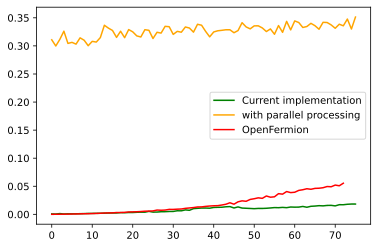

In [63]:
from matplotlib import pyplot as plt

plt.plot(Y_symp, color='green', label='Current implementation')
plt.plot(Y_para, color='orange', label='with parallel processing')
plt.plot(Y_open[:73], color='red', label='OpenFermion')

plt.legend()

In [ ]:
%timeit multiplication_2(P)

In [48]:
P = random_PauliwordOp(3, 2)
P_OF = sum(P.PauliwordOp_to_OF)
print(P*P)
P_OF * P_OF

0.595+0.418j III


(0.5948691680516037+0.41844660603169004j) []

In [144]:
import time

def runtime(func, obj, n_samples=10):
    samples = []
    for sample in range(n_samples):
        start = time.time()
        func(obj)
        stop = time.time()
        samples.append(stop - start)
    return sum(samples)/n_samples

def square(op):
    return op*op
def square_qiskit(op):
    return (op@op).to_pauli_op()

Y_symp=[]
Y_cirq=[]
Y_qisk=[]

for n_terms in range(1,100):
    print(n_terms)
    P = random_PauliwordOp(10, n_terms)
    P_cirq = sum(P.PauliwordOp_to_OF)
    P_qisk = P.to_PauliSumOp
    
    Y_symp.append(runtime(multiplication_1, obj=P))
    Y_cirq.append(runtime(square, obj=P_cirq))
    Y_qisk.append(runtime(square_qiskit, obj=P_qisk))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71


KeyboardInterrupt: 

NameError: name 'Y_cirq' is not defined

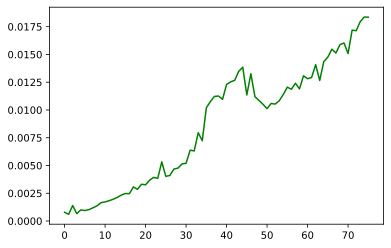

In [52]:
from matplotlib import pyplot as plt

plt.plot(Y_symp, color='green', label='Symplectic')
plt.plot(Y_cirq, color='orange', label='OpenFermion')
plt.plot(Y_qisk, color='red', label='Qiskit')

plt.legend()

In [122]:
P_OF = sum(P.PauliwordOp_to_OF)

%timeit P_OF * P_OF

2.52 s ± 8.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [2]:
def _multiply_single_Pword(self, 
        Pword:"PauliwordOp"
    ) -> "PauliwordOp":
    """ performs Pauli multiplication with phases. The phase compensation 
    is implemented as per https://doi.org/10.1103/PhysRevA.68.042318
    """
    phaseless_prod_Pword = self._multiply_single_Pword_phaseless(Pword)

    # counts ZX mismatches for sign flip
    assert(Pword.n_terms==1), 'not single Pauliword'
    num_sign_flips = np.einsum('ij->i', np.bitwise_and(self.X_block, Pword.Z_block))
    sign_change = (-1) ** num_sign_flips

    # mapping from sigma to tau representation
    full_Y_count = self.Y_count + Pword.Y_count
    sigma_tau_compensation = (-1j) ** full_Y_count

    # back from tau to sigma (note uses output Pword)
    tau_sigma_compensation = (1j) ** phaseless_prod_Pword.Y_count

    # the full phase modification
    phase_mod = sign_change * sigma_tau_compensation * tau_sigma_compensation
    phaseless_prod_Pword.coeff_vec = phase_mod * self.coeff_vec * Pword.coeff_vec

    return phaseless_prod_Pword

In [3]:
from symred.symplectic import random_PauliwordOp

In [63]:
n_q = 5
n_t = 5

P = random_PauliwordOp(n_q, n_t)
Q = random_PauliwordOp(n_q, n_t)

In [78]:
import numpy as np

self = P

def _multiply_single_symplectic(self, Pword):
    assert(Pword.n_terms==1), 'not single Pauliword'
    # updated symp_matrix (Pauli multiplication corresponds with binary addition of symplectic matrices)
    pauli_mult_phaseless = np.bitwise_xor(self.symp_matrix, Pword.symp_matrix)
    
    # counts ZX mismatches for sign flip
    num_sign_flips = np.einsum('ij->i', np.bitwise_and(self.X_block, Pword.Z_block))
    sign_change = (-1) ** num_sign_flips

    # mapping from sigma to tau representation
    full_Y_count = self.Y_count + Pword.Y_count
    sigma_tau_compensation = (-1j) ** full_Y_count

    # back from tau to sigma (note uses output Pword)
    tau_sigma_compensation = (1j) ** phaseless_prod_Pword.Y_count

    # the full phase modification
    phase_mod = sign_change * sigma_tau_compensation * tau_sigma_compensation
    #phaseless_prod_Pword.coeff_vec = phase_mod * self.coeff_vec * Pword.coeff_vec
     
    return pauli_mult_phaseless, phase_mod

_multiply_single_symplectic(self=P, Pword=Q[0])

NameError: name 'phaseless_prod_Pword' is not defined